# Gaussian Process Regression Testing

In this notebook I want to compare python implementations of Gaussian Process regression in 3D with the Scalismo library written in Scala

Two methods will be used: 
- Sklearn https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html 
- GPyTorch https://docs.gpytorch.ai/en/stable/index.html 

While the Sklearn implementation is simpler (and maybe more flexible), the GPytorch is modularized to be able to run on the GPU - having the potential for a lot of speed-up!

In [1]:
%load_ext autoreload
%autoreload 2
import time
import numpy as np
import ipytest
import torch 
import gpytorch
import matplotlib.pyplot as plt

from tqdm import tqdm

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

from typing import Union

In [2]:
ipytest.autoconfig(raise_on_error=True)
print("Using PyTorch", torch.__version__, "and GPyTorch", gpytorch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using this device: {device}")

Using PyTorch 2.4.0+cu121 and GPyTorch 1.12
Using this device: cuda


## Vectorization
First of some vectorization and unvectorization functions + tests to see if it works for both torch tensors and numpy arrays. 
This manual vectorization is used in Scalismo but for Sklearn and Gpytorch we can directly input our 3D data.

In [3]:
def vectorize(data: Union[np.ndarray, torch.Tensor]) -> Union[np.ndarray, torch.Tensor]:
    if isinstance(data, np.ndarray):
        return data.flatten()
    elif isinstance(data, torch.Tensor):
        return data.view(-1)
    else:
        raise TypeError("Input must be either a numpy array or a PyTorch tensor")


def unvectorize(
    data: Union[np.ndarray, torch.Tensor], dim: int
) -> Union[np.ndarray, torch.Tensor]:
    if isinstance(data, np.ndarray):
        n = int(len(data) / dim)
        return data.reshape((n, dim))
    elif isinstance(data, torch.Tensor):
        n = int(data.numel() / dim)
        return data.view(n, dim)
    else:
        raise TypeError("Input must be either a numpy array or a PyTorch tensor")

In [4]:
%%ipytest -s
# | code-fold: true

def test_vectorize():
    input_data = torch.tensor([[1, 2, 3], [4, 5, 6]])
    expected_output = torch.tensor([1, 2, 3, 4, 5, 6])
    assert torch.all(vectorize(input_data).eq(expected_output))
    assert np.array_equal(vectorize(input_data).numpy(), expected_output.numpy())

def test_unvectorize():
    input_data = torch.tensor([1, 2, 3, 4, 5, 6])
    expected_output = torch.tensor([[1, 2, 3], [4, 5, 6]])
    assert torch.all(unvectorize(input_data, 3).eq(expected_output))
    assert np.array_equal(unvectorize(input_data.numpy(), 3), expected_output.numpy())

def vectorize_unvectorize_roundtrip(data: Union[np.ndarray, torch.Tensor]) -> bool:
    vectorized = vectorize(data)
    unvectorized = unvectorize(vectorized, data.shape[1])
    if isinstance(data, torch.Tensor):
        return torch.all(data.eq(unvectorized))
    else:
        return np.array_equal(data, unvectorized)

def test_vectorize_unvectorize_roundtrip():
    input_data = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 9.0]])
    assert vectorize_unvectorize_roundtrip(input_data)
    assert vectorize_unvectorize_roundtrip(input_data.numpy())

    random_data = torch.rand(10, 5)
    assert vectorize_unvectorize_roundtrip(random_data)
    assert vectorize_unvectorize_roundtrip(random_data.numpy())

...
========================================= warnings summary =========================================
../../../../../home/dennis/miniconda3/envs/mynotebooks/lib/python3.10/site-packages/_pytest/config/__init__.py:1273
  /home/dennis/miniconda3/envs/mynotebooks/lib/python3.10/site-packages/_pytest/config/__init__.py:1273: PytestAssertRewriteWarning: Module already imported so cannot be rewritten: jaxtyping
    self._mark_plugins_for_rewrite(hook)

-- Docs: https://docs.pytest.org/en/stable/how-to/capture-warnings.html
3 passed, 1 warning in 0.01s


# Sklearn example in 3D

In [5]:
# Setup data for GPR
plot_data = True
board_size = 100
if plot_data:
    board_size = 20
num_points = board_size * board_size

noise_levels = [1.0]
if plot_data:
    noise_levels = [1.0, 2.0, 5.0]

z_pos = board_size / 2.0  # 0.0
i, j = np.indices((board_size, board_size))
points = np.stack((i, j, np.ones_like(i) * z_pos), axis=-1).reshape(-1, 3)

print(f"Total number of points: {int(points.size/3):,}")


def plot_3d(ax, X, Y, Z, title):
    # zs = np.zeros(num_points)
    # dx = np.ones(num_points)
    # dy = np.ones(num_points)
    # ax.bar3d(X, Y, zs, dx, dy, Z)
    ax.scatter(X, Y, Z)
    ax.set_title(title)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_xlim([0, board_size])
    ax.set_ylim([0, board_size])
    ax.set_zlim([0, board_size])


pos_points = [points[0], points[int(board_size**2 / 2 - board_size / 2)]]

deformation_vector = np.array([0, 0, board_size])
deformation_point_0 = np.array(pos_points[0])
deformation_point_1 = np.array(pos_points[1])

X = np.array([deformation_point_0, deformation_point_1])
y = np.array([deformation_vector, deformation_vector])

kernel_rbf = RBF(length_scale=1.0)  # + WhiteKernel(noise_level=1.0)

Total number of points: 400


Calling fit
Calling predict
Execution time posterior: 0.01s with noise: 1.0
Execution time adding: 0.00s with noise: 1.0
Calling fit
Calling predict
Execution time posterior: 0.01s with noise: 2.0
Execution time adding: 0.00s with noise: 2.0
Calling fit
Calling predict
Execution time posterior: 0.01s with noise: 5.0
Execution time adding: 0.00s with noise: 5.0


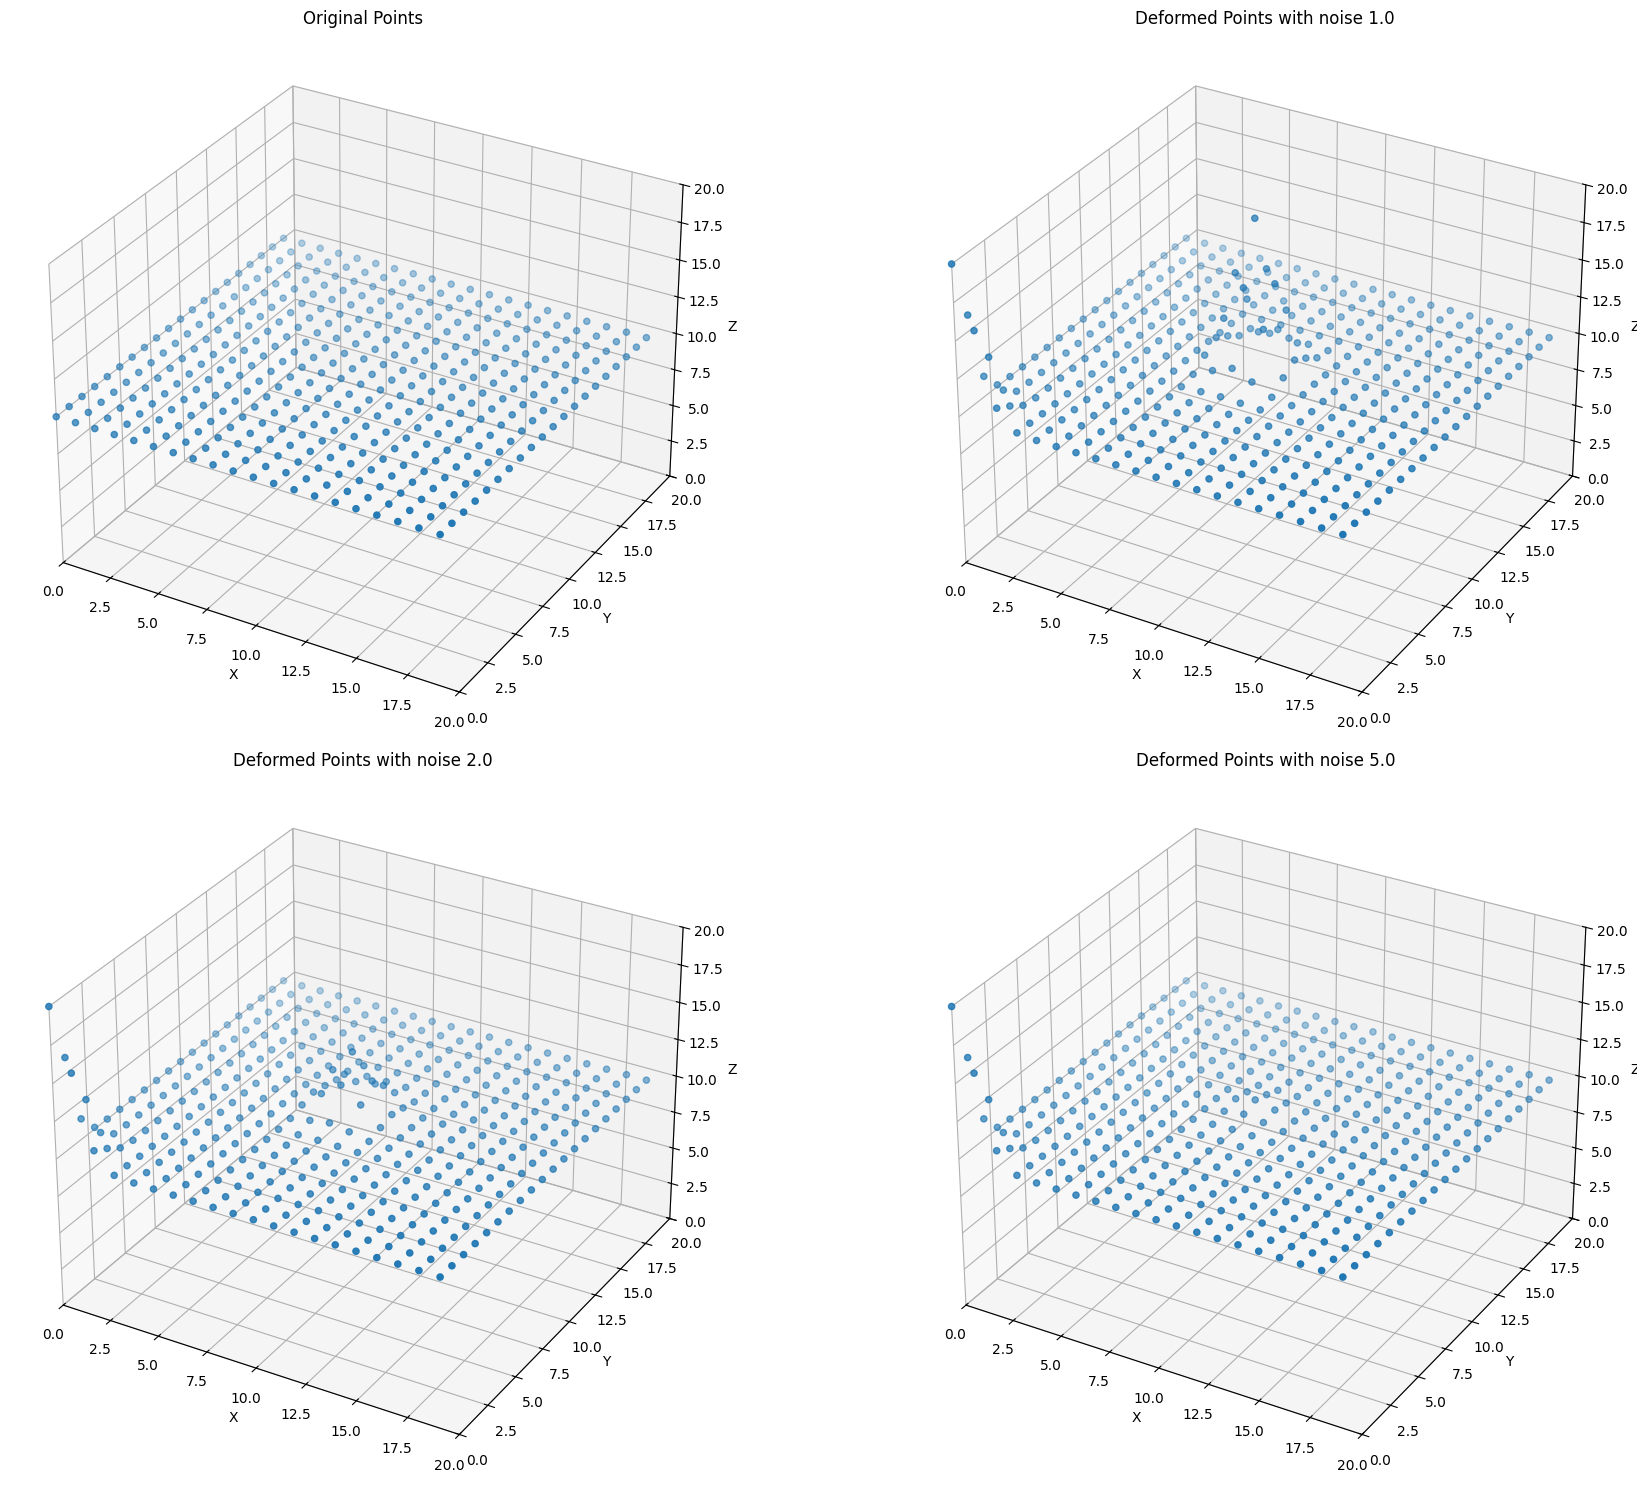

In [6]:
if plot_data:
    fig = plt.figure(figsize=(20, 15))
    ax = fig.add_subplot(2, 2, 1, projection="3d")
    plot_3d(ax, points[:, 0], points[:, 1], points[:, 2], "Original Points")

for i, noise in enumerate(noise_levels):

    gpr = GaussianProcessRegressor(kernel=kernel_rbf, alpha=np.array([1.0, noise**2]))

    start_time = time.time()
    print("Calling fit")
    gpr.fit(X, y)
    print("Calling predict")
    predicted_deformation_field = gpr.predict(points)

    mid_time = time.time()
    new_points = points + predicted_deformation_field

    end_time = time.time()
    execution_time_pos = mid_time - start_time
    execution_time_add = end_time - mid_time
    print(f"Execution time posterior: {execution_time_pos:.2f}s with noise: {noise}")
    print(f"Execution time adding: {execution_time_add:.2f}s with noise: {noise}")

    if plot_data:
        ax = fig.add_subplot(2, 2, i + 2, projection="3d")
        plot_3d(
            ax,
            new_points[:, 0],
            new_points[:, 1],
            new_points[:, 2],
            f"Deformed Points with noise {noise}",
        )

if plot_data:
    plt.tight_layout()
    plt.show()

# Simple 1D example with variable noise terms in Gpytorch
- Using Multitask model but with num_task=1 (such that it is similar to using a standard MultivariateNormal

In [7]:
train_x = torch.tensor([0.01, 0.3, 0.6, 0.99]).unsqueeze(-1)
train_y = torch.tensor([1.0, -2.0, 2.0, -4.0]).unsqueeze(-1)
observation_noise = torch.tensor([1.0, 0.001, 5.0, 0.1])

# Simple 1D example
# class ExactGPModel(gpytorch.models.ExactGP):
#     def __init__(self, train_x, train_y, likelihood):
#         super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
#         self.kernel = gpytorch.kernels.RBFKernel()
#         self.kernel.lengthscale = 1.0
#         self.mean_module = gpytorch.means.ZeroMean()
#         self.covar_module = gpytorch.kernels.ScaleKernel(self.kernel)
#         self.covar_module.outputscale = 1.0

#     def forward(self, x):
#         mean_x = self.mean_module(x)
#         covar_x = self.covar_module(x)
#         return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


# Multi-task GP example with 1D input/output
class MultitaskExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskExactGPModel, self).__init__(train_x, train_y, likelihood)

        self.num_tasks = 1

        self.base_kernel = gpytorch.kernels.RBFKernel()
        self.base_kernel.lengthscale = 1.0

        self.covar_module = gpytorch.kernels.MultitaskKernel(
            self.base_kernel, num_tasks=self.num_tasks, rank=1
        )
        self.covar_module.outputscale = 1.0

        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ZeroMean(), num_tasks=self.num_tasks
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

In [8]:
# initialize likelihood and model
likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(
    noise=observation_noise, learn_additional_noise=False
)
model = MultitaskExactGPModel(train_x, train_y, likelihood)
optimizer = torch.optim.Adam(
    model.parameters(), lr=0.1
)  # Includes GaussianLikelihood parameters
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 50

pbar = tqdm(range(training_iter), desc="Training")

model.train()
likelihood.train()
for _ in pbar:
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    pbar.set_description(f"Loss: {loss.item():.3f}, Noise: {noise}")
    optimizer.step()

Training:   0%|          | 0/50 [00:00<?, ?it/s]/home/dennis/miniconda3/envs/mynotebooks/lib/python3.10/site-packages/gpytorch/likelihoods/gaussian_likelihood.py:347: GPInputWarning: You have passed data through a FixedNoiseGaussianLikelihood that did not match the size of the fixed noise, *and* you did not specify noise. This is treated as a no-op.
  warnings.warn(
Loss: 6.077, Noise: 5.0: 100%|██████████| 50/50 [00:00<00:00, 194.37it/s] 


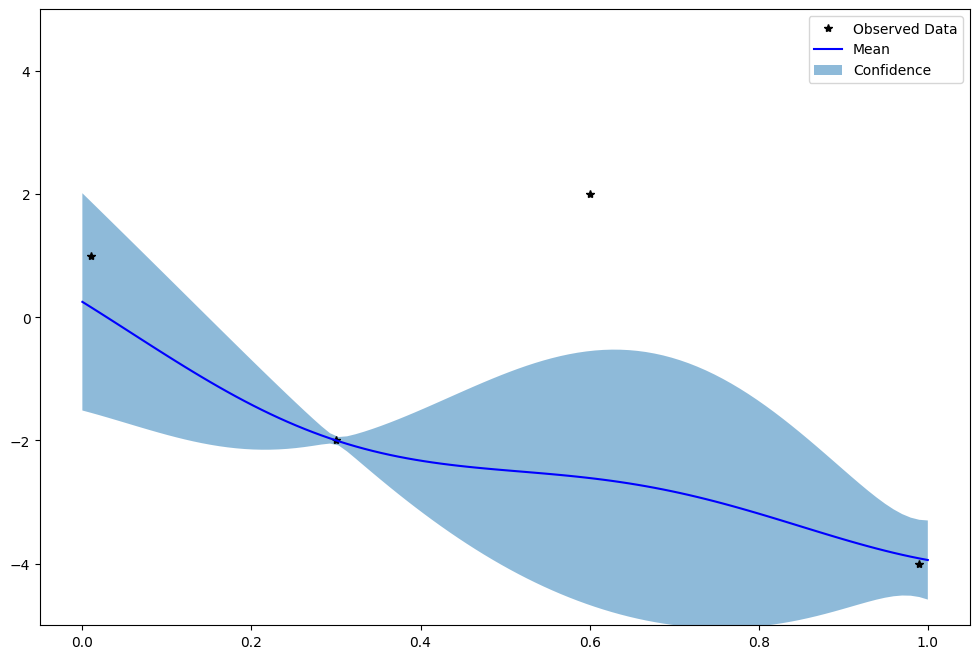

In [9]:
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 100)
    observed_pred = likelihood(model(test_x))

with torch.no_grad():
    f, ax = plt.subplots(1, 1, figsize=(12, 8))

    lower, upper = observed_pred.confidence_region()
    lower = lower.squeeze().numpy()
    upper = upper.squeeze().numpy()
    ax.plot(train_x.numpy(), train_y.numpy(), "k*")
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), "b")
    ax.fill_between(test_x.numpy(), lower, upper, alpha=0.5)
    ax.set_ylim([-5, 5])
    ax.legend(["Observed Data", "Mean", "Confidence"])

# Gpytorch example in 3D
In Gpytorch dimensions are refered to as tasks. So by setting 'num_tasks=3', the model takes 3D data as input.
1. define the model (zero mean and RFB kernel)
2. Extend the MultitaskGaussianLikelihood kernel to allow for observation independent noise to be defined (as in the above 1D example)
3. GPR 

In [10]:
import torch
import gpytorch
from tqdm.notebook import tqdm

# GPYTORCH paper from 2018 (NeurIPS) https://arxiv.org/pdf/1809.11165


class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ZeroMean(), num_tasks=3
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.RBFKernel(), num_tasks=3, rank=0
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)


# Convert numpy arrays to PyTorch tensors
points_tensor = torch.tensor(points, dtype=torch.float32).to(device)

In [24]:
from gpytorch.likelihoods import MultitaskGaussianLikelihood
from gpytorch.constraints import GreaterThan
from linear_operator.operators import DiagLinearOperator
import torch


class MultitaskFixedNoiseGaussianLikelihood(MultitaskGaussianLikelihood):
    def __init__(
        self,
        num_tasks,
        independent_noise,
        noise_constraint=None,
        noise=0.0001,
        **kwargs
    ):
        # Ensure independent noise is provided
        if independent_noise is None:
            raise ValueError("independent_noise must be provided")

        # Initialize the parent class with fixed global noise
        super().__init__(
            num_tasks, has_global_noise=True, has_task_noise=False, rank=0, **kwargs
        )

        # Set the global noise to a constant value
        self.noise = noise

        # Set up independent noise
        if noise_constraint is None:
            noise_constraint = GreaterThan(1e-4)
        self.register_parameter(
            name="raw_independent_noise", parameter=torch.nn.Parameter(torch.zeros(1))
        )
        self.register_constraint("raw_independent_noise", noise_constraint)
        self._set_independent_noise(independent_noise)

    def _set_independent_noise(self, value):
        if not torch.is_tensor(value):
            value = torch.tensor(value)
        if value.ndim == 0:
            value = value.unsqueeze(0)
        transformed_value = self.raw_independent_noise_constraint.inverse_transform(
            value
        )
        self.raw_independent_noise.data = transformed_value

    def _shaped_noise_covar(self, base_shape, *params, **kwargs):
        # noise_covar = super()._shaped_noise_covar(base_shape, *params, **kwargs) - include if wanting a global noise term

        independent_noise = self.raw_independent_noise_constraint.transform(
            self.raw_independent_noise
        )

        if independent_noise.shape[0] < base_shape[-2]:
            last_noise = independent_noise[-1]
            independent_noise = torch.cat(
                [
                    independent_noise,
                    last_noise.expand(base_shape[-2] - independent_noise.shape[0]),
                ]
            )
        elif independent_noise.shape[0] > base_shape[-2]:
            independent_noise = independent_noise[: base_shape[-2]]

        independent_noise = independent_noise.repeat_interleave(self.num_tasks)
        independent_noise_covar = DiagLinearOperator(independent_noise)
        noise_covar = independent_noise_covar

        return noise_covar

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Execution time posterior: 1.28s with noise: 1.0
Execution time adding: 0.00s with noise: 1.0


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Execution time posterior: 1.46s with noise: 2.0
Execution time adding: 0.00s with noise: 2.0


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Execution time posterior: 1.24s with noise: 5.0
Execution time adding: 0.00s with noise: 5.0


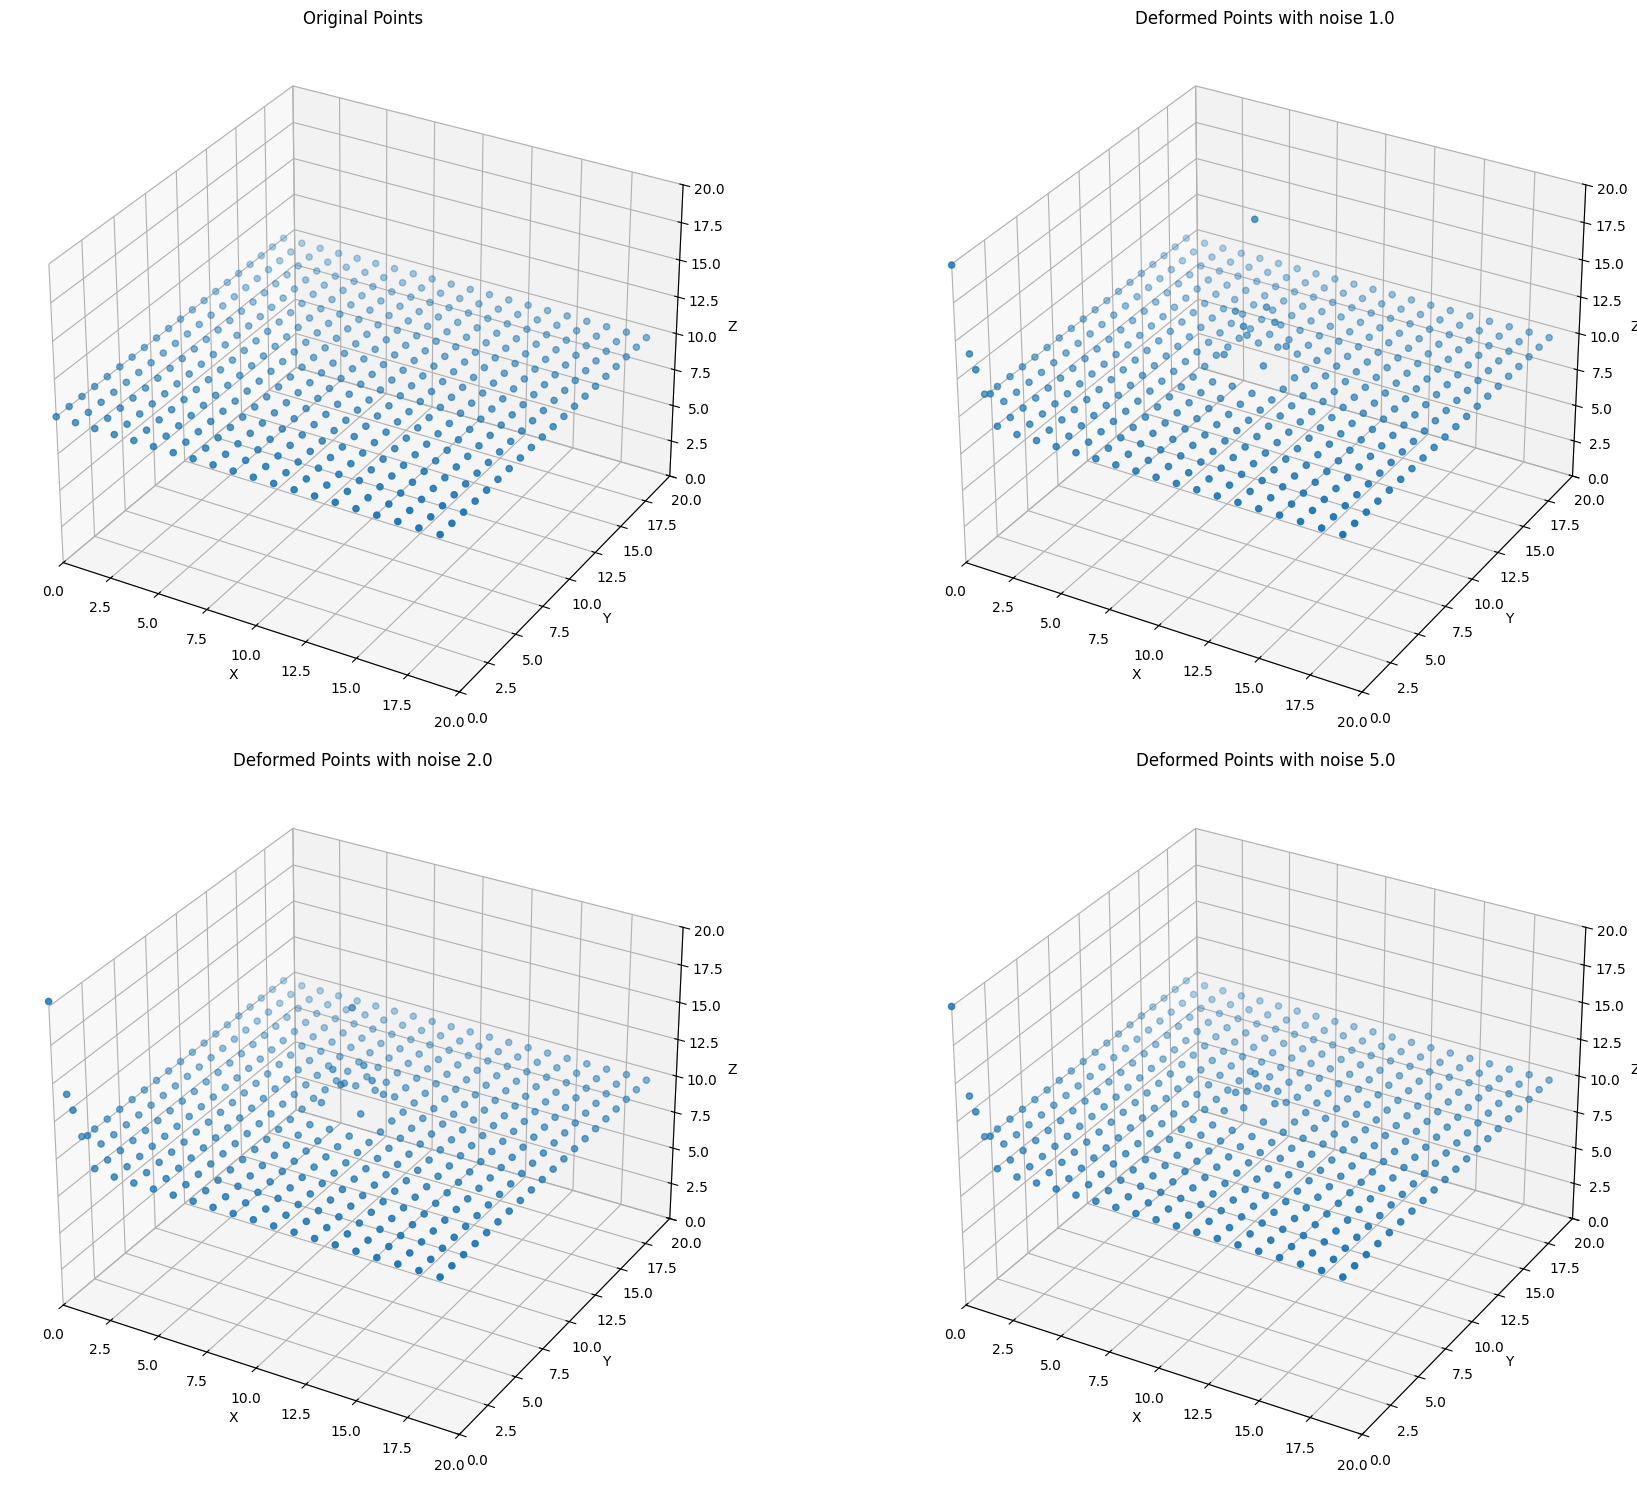

In [25]:
if plot_data:
    fig = plt.figure(figsize=(20, 15))
    ax = fig.add_subplot(2, 2, 1, projection="3d")
    plot_3d(ax, points[:, 0], points[:, 1], points[:, 2], "Original Points")

deformation_vector = torch.tensor([0, 0, board_size], dtype=torch.float32).to(device)
deformation_point_0 = torch.tensor(pos_points[0], dtype=torch.float32).to(device)
deformation_point_1 = torch.tensor(pos_points[1], dtype=torch.float32).to(device)

for i, noise in enumerate(noise_levels):
    # Create the input data for GPyTorch
    X = torch.stack([deformation_point_0, deformation_point_1]).to(device)
    y = torch.stack([deformation_vector, deformation_vector]).to(device)

    # Fixed noise likelihood - Does not work with multiple tasks
    # fixed_noise = torch.tensor([1.0, 1.0, 1.0, noise**2, noise**2, noise**2])
    # likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(noise = fixed_noise, learn_additional_noise=False).to(device)

    # Multitask Likelihood - Only sets global noise for all observations and for all tasks
    # Now with MyMultitask likelihood we can also set "independet noise" for each observation!
    # likelihood = MultitaskGaussianLikelihood(
    likelihood_independent_noise = torch.tensor([1.0, noise**2]).to(device)
    likelihood = MultitaskFixedNoiseGaussianLikelihood(
        num_tasks=3,
        independent_noise=likelihood_independent_noise,
    ).to(device)
    # likelihood.noise = 0.0001

    model = MultitaskGPModel(X, y, likelihood).to(device)

    # Use the built-in GP model optimizer
    model.train()
    likelihood.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    start_time = time.time()

    training_iter = 100

    pbar = tqdm(range(training_iter), desc="Training")

    # Train the model
    for _ in pbar:
        optimizer.zero_grad()
        output = model(X)
        loss = -mll(output, y)
        loss.backward()
        optimizer.step()
        pbar.set_description(f"Loss: {loss.item():.3f}, Noise: {noise}")

    # Make predictions
    model.eval()
    likelihood.eval()
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        predicted_distribution = likelihood(model(points_tensor))
        predicted_mean = predicted_distribution.mean
        predicted_variance = predicted_distribution.variance

    mid_time = time.time()
    new_points = points_tensor + predicted_mean

    end_time = time.time()
    execution_time_pos = mid_time - start_time
    execution_time_add = end_time - mid_time
    print(f"Execution time posterior: {execution_time_pos:.2f}s with noise: {noise}")
    print(f"Execution time adding: {execution_time_add:.2f}s with noise: {noise}")

    if plot_data:
        ax = fig.add_subplot(2, 2, i + 2, projection="3d")
        new_points_cpu = new_points.cpu().numpy()
        plot_3d(
            ax,
            new_points_cpu[:, 0],
            new_points_cpu[:, 1],
            new_points_cpu[:, 2],
            f"Deformed Points with noise {noise}",
        )

if plot_data:
    plt.tight_layout()
    plt.show()

# Next steps
 - Implement .h5 shape model loader
 - Load pre-computed kernel into Gpytorch